In [1]:
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import copy
import h5py
import numpy as np
import matplotlib
import re

import matplotlib.pyplot as plt
from dedalus.extras import plot_tools

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

import os
from os import listdir

from numpy.linalg import svd, pinv
from scipy.linalg import eig

No protocol specified


In [2]:
Lx, Ly, Lz = 4,4,1
Nx, Ny, Nz = 128, 128, 32

Ra_D = -1.24e5
Prandtl = 0.7
N_s2 = 2

D_0 = 0
D_H = 1
M_0 = 0
M_H = -1

dealias = 3/2
stop_sim_time = 1500
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

nu = (Ra_D / (Prandtl*(D_0-D_H)*Lz**3))**(-1/2)

In [3]:
folder_dir = "analysis"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
print(file_paths)

['analysis/analysis_s1.h5', 'analysis/analysis_s2.h5']


In [44]:
np.concatenate((np.array([[1, 2, 3]]), np.array([[7, 8, 9]])))

array([[1, 2, 3],
       [7, 8, 9]])

In [4]:
def get_all_data(task, Nz):
    recorded = False
    for file in file_paths:
        with h5py.File(file, mode='r') as file:
            st = file['scales/sim_time']
            simtime = np.array(st)
            avg_0 = file["tasks"][task]
            avg = np.reshape(avg_0, (len(simtime),Nz))
            for t in range(len(simtime)):
                avg_T=np.transpose(avg[t,:])
                avg_T = np.reshape(avg_T, (1, Nz))
                if recorded == False:
                    avg_all_time = avg_T
                    recorded = True
                else:
                    avg_all_time = np.concatenate((avg_all_time, avg_T))
    print(np.shape(avg_all_time))
    print(np.shape(np.transpose(avg_all_time[:,:])))
    avg_allt_T=np.transpose(avg_all_time[:,:])
    return avg_allt_T
def draw_contour(avg_allt_T, task):
    plt.contourf(avg_allt_T, cmap='Spectral_r')
    plt.colorbar(label=f'{task}')
    plt.xlabel('time')
    plt.ylabel('z')
    plt.title(f'{task} vs time')
    plt.savefig(f'{task.replace(" ", "_")}.png', dpi=200,bbox_inches='tight')
    plt.show()
    matplotlib.pyplot.close()

(1500, 32)
(32, 1500)
(1500, 32)
(32, 1500)
(1500, 32)
(32, 1500)


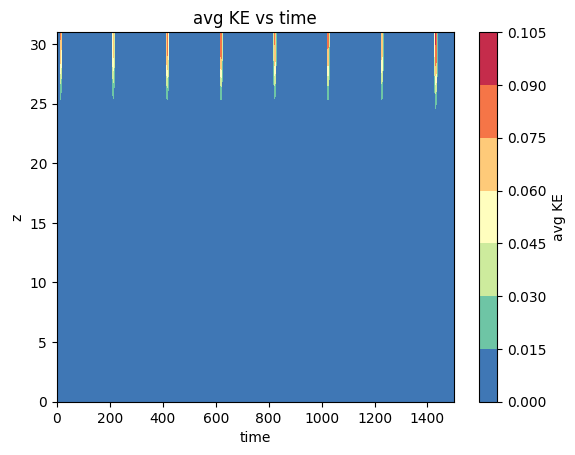

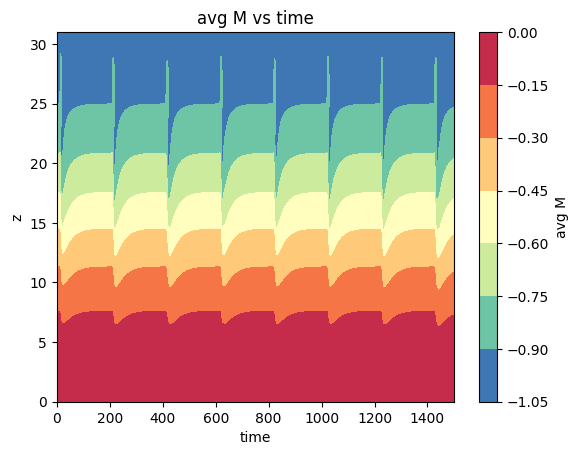

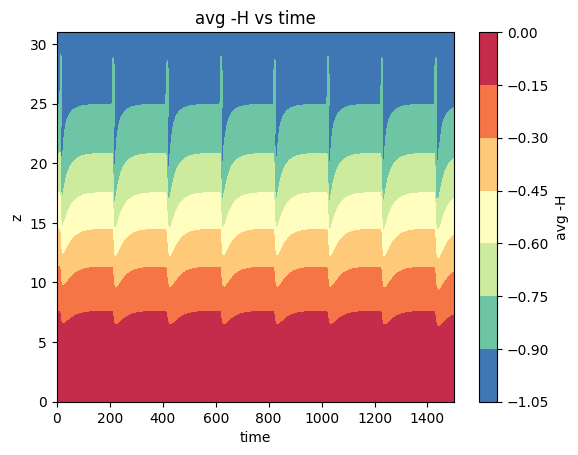

In [5]:
avg_KE_all_time = get_all_data("avg KE by xy", Nz)
avg_M_all_time = get_all_data("avg M by xy", Nz)
avg_nD_all_time = get_all_data("avg -D by xy", Nz)
draw_contour(avg_KE_all_time, "avg KE")
draw_contour(avg_M_all_time, "avg M")
draw_contour(avg_nD_all_time, "avg -H")

In [6]:

def DMD(mat_A, r=None):
    """
    Perform Dynamic Mode Decomposition (DMD) on the dataset KE_all_time.

    Parameters:
    - KE_all_time: NumPy array of shape (32, 2000), where each column is a data snapshot.
    - r: Number of singular values/modes to keep. If None, use full rank.

    Returns:
    - Phi: DMD modes
    - Lambda: Eigenvalues of the DMD modes
    - b: Amplitudes of the DMD modes
    """

    # Step 1: Prepare the data matrices X and X'
    X = mat_A[:, :-1]
    X_prime = mat_A[:, 1:]

    # Step 2: Perform SVD on X
    U, Sigma, Vh = svd(X, full_matrices=False) # it is in the reduced form
    if r is not None:
        U = U[:, :r]
        Sigma = Sigma[:r]
        Vh = Vh[:r, :]

    # Step 3: Compute the pseudo-inverse of Sigma for the best-fit linear operator
    Sigma_inv = np.diag(1.0 / Sigma)

    # Compute the approximate linear operator A_tilde
    A_tilde = U.T @ X_prime @ Vh.T @ Sigma_inv

    # Step 4: Compute eigenvalues and eigenvectors of A_tilde
    Lambda, W = eig(A_tilde)

    # Compute DMD modes
    Phi = X_prime @ Vh.T @ Sigma_inv @ W

    # Compute DMD amplitudes
    b = pinv(Phi) @ mat_A[:, 0]

    return Phi, Lambda, b

# Assuming KE_all_time is your (32, 4000) data array
# KE_all_time = np.random.rand(32, 4000)  # Example initialization, replace with your data

# Perform DMD (specify 'r' as needed, e.g., r=10 for top 10 modes)
# Phi, Lambda, b = DMD(KE_all_time, r=10)

# Now, Phi contains the DMD modes, Lambda contains the eigenvalues, and b contains the mode amplitudes

def compute_future_states(PHI, LAMBDA, B, TIMESTEPS, DT):
    """
    Compute the approximate solution at future times using DMD.

    Parameters:
    - Phi: DMD modes.
    - Lambda: Eigenvalues of the DMD modes.
    - b: Amplitudes of the DMD modes.
    - timesteps: Number of future time steps to compute.
    - dt: Time step between measurements in the original data.

    Returns:
    - X_future: The approximate future states of the system.
    """
    omega = np.log(LAMBDA) / DT
    t = np.arange(TIMESTEPS) * DT
    X_future = np.zeros((PHI.shape[0], TIMESTEPS), dtype=np.complex_)

    for i in range(TIMESTEPS):
        X_future[:, i] = np.dot(PHI, B * np.exp(omega * t[i]))
    
    return X_future.real

# Assuming KE_all_time is your data and you've already computed Phi, Lambda, b
# For example purposes, let's set some parameters
# Number of future time steps to predict
# Time step between snapshots in your original data

# Compute future states
# X_future = compute_future_states(Phi, Lambda, b, timesteps, dt)

# Note: This code assumes a consistent time step 'dt' between your original data snapshots.
# 'X_future' will contain the real part of the future states of the system.
# Adjust 'timesteps' and 'dt' as needed for your specific application.


In [7]:
def local_look(begin_time, end_time, data_all, name):
    datasample = data_all[:, begin_time:end_time]
    phi, Lam, b = DMD(datasample)
    dt = 1
    timesteps = 500
    future_data = compute_future_states(phi, Lam, b, timesteps, 1)
    n_rows, n_columns = datasample.shape
    x_ax = np.linspace(begin_time, end_time, n_columns)
    y_ax = np.linspace(0, n_rows-1, n_rows)
    X_ax, Y_ax = np.meshgrid(x_ax, y_ax)
    plt.figure(figsize=(16, 4))
    plt.subplot(1,2,1)
    plt.contourf(X_ax, Y_ax, datasample, cmap='Spectral_r')
    plt.colorbar(label=f'avg_{name}')
    plt.xlabel('time')
    plt.ylabel('z')
    plt.title(f'avg {name} by z vs time')
    # plt.savefig(f'.png', dpi=200,bbox_inches='tight')
    plt.subplot(1,2,2)
    plt.contourf(future_data, cmap='Spectral_r')
    plt.colorbar(label=f'avg_{name}')
    plt.xlabel('time')
    plt.ylabel('z')
    plt.title(f'avg {name} by z vs time')
    # plt.savefig(f'.png', dpi=200,bbox_inches='tight')
    plt.show()
    plt.clf()

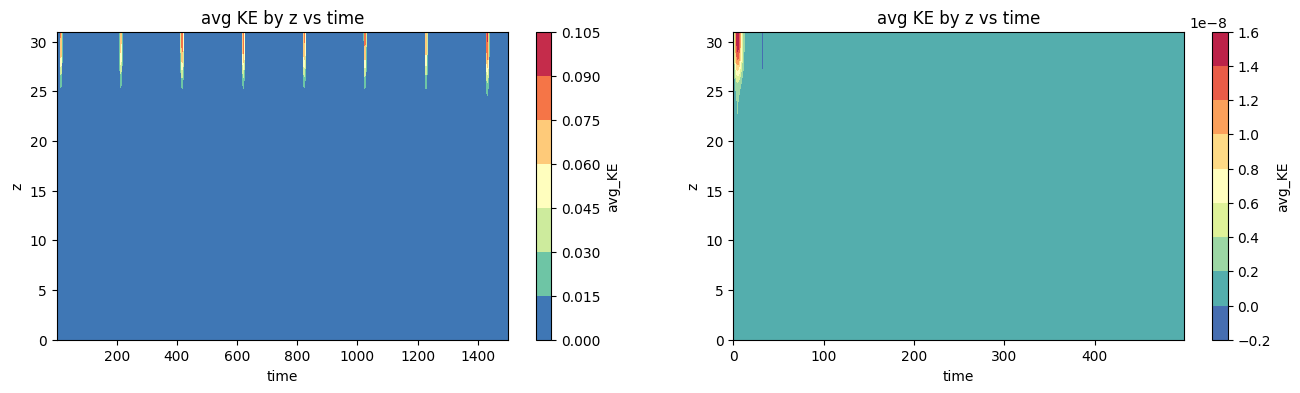

<Figure size 640x480 with 0 Axes>

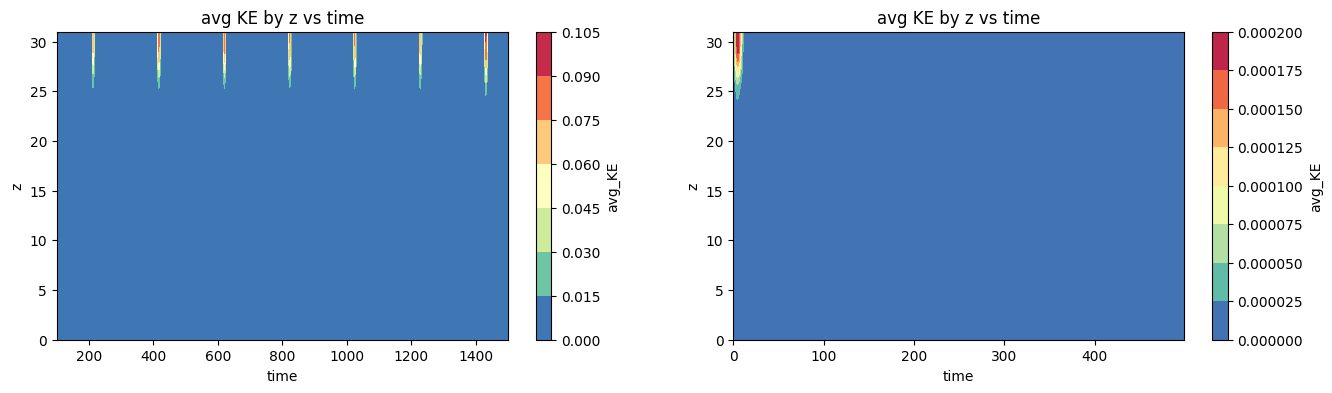

<Figure size 640x480 with 0 Axes>

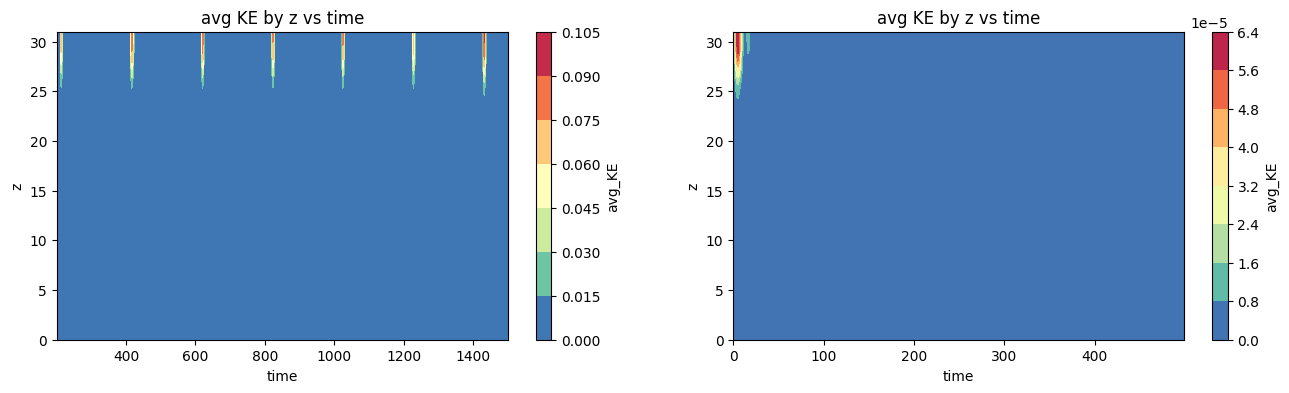

<Figure size 640x480 with 0 Axes>

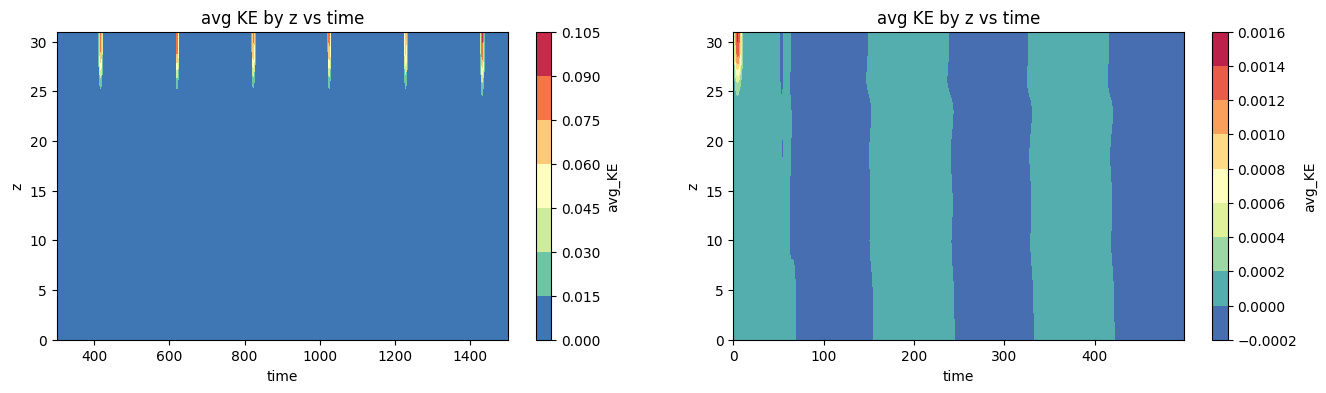

<Figure size 640x480 with 0 Axes>

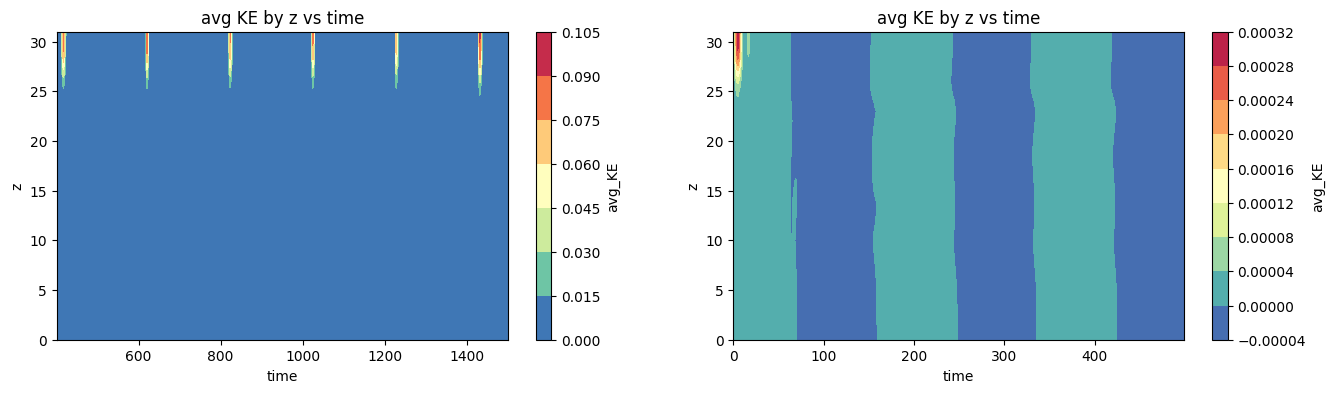

<Figure size 640x480 with 0 Axes>

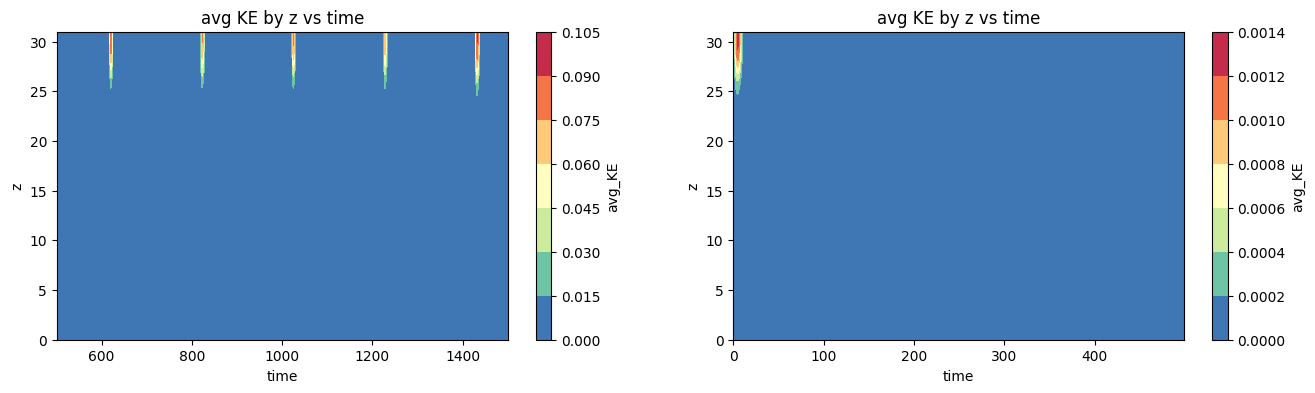

<Figure size 640x480 with 0 Axes>

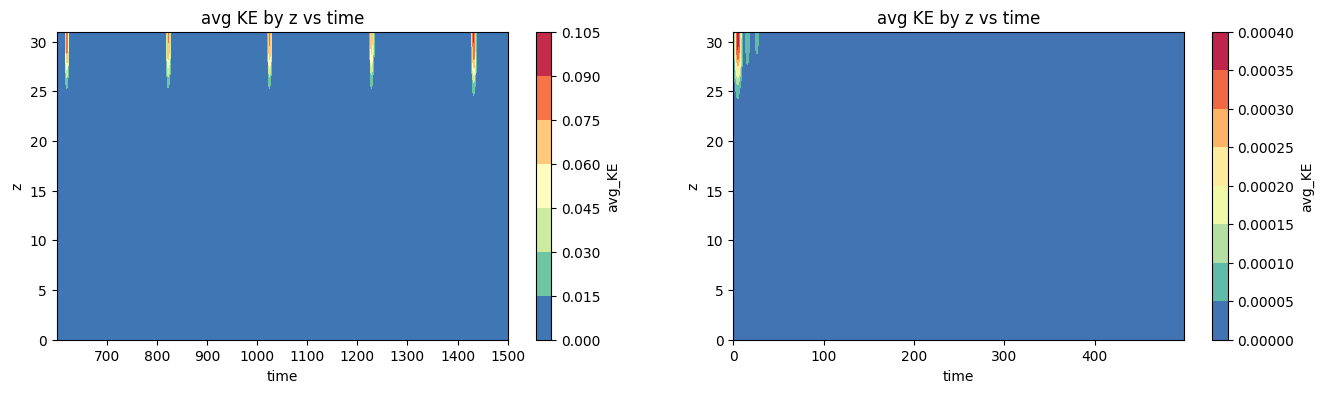

<Figure size 640x480 with 0 Axes>

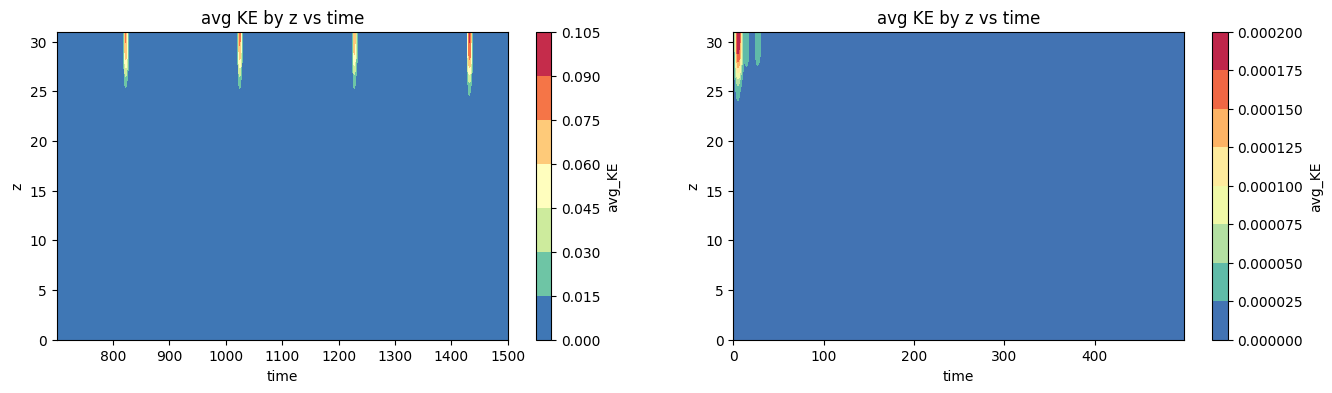

<Figure size 640x480 with 0 Axes>

In [18]:
for beginning_time in range(1, 800, 100):
    local_look(beginning_time, 1500, avg_KE_all_time, 'KE')


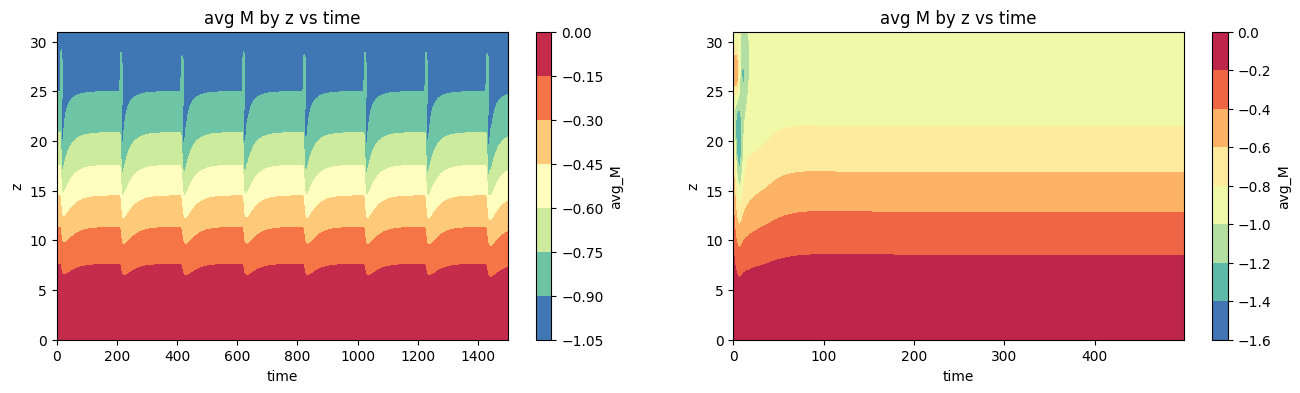

<Figure size 640x480 with 0 Axes>

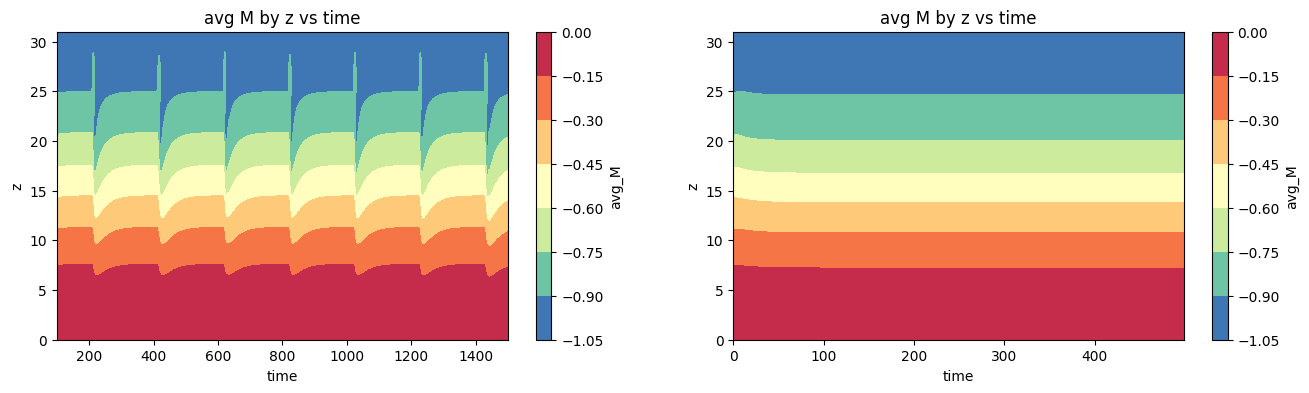

<Figure size 640x480 with 0 Axes>

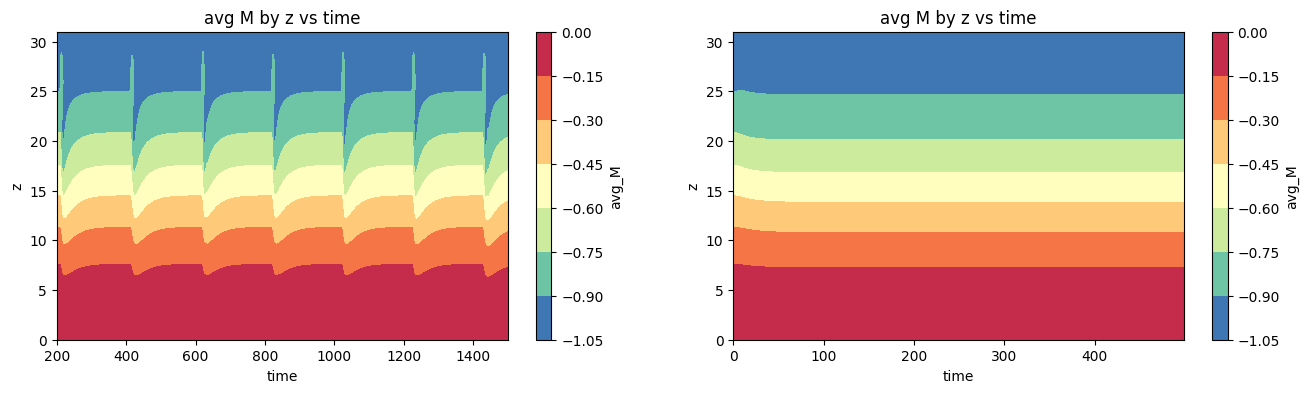

<Figure size 640x480 with 0 Axes>

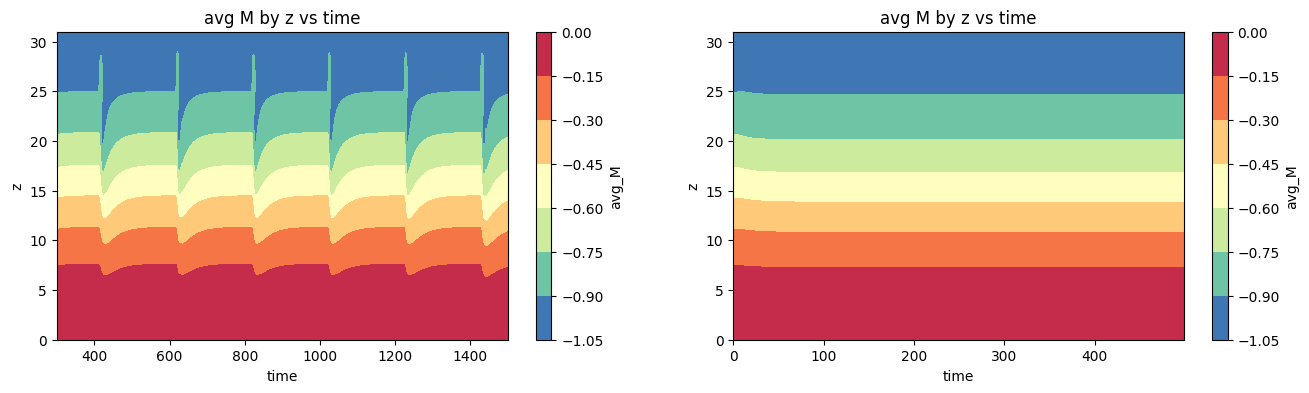

<Figure size 640x480 with 0 Axes>

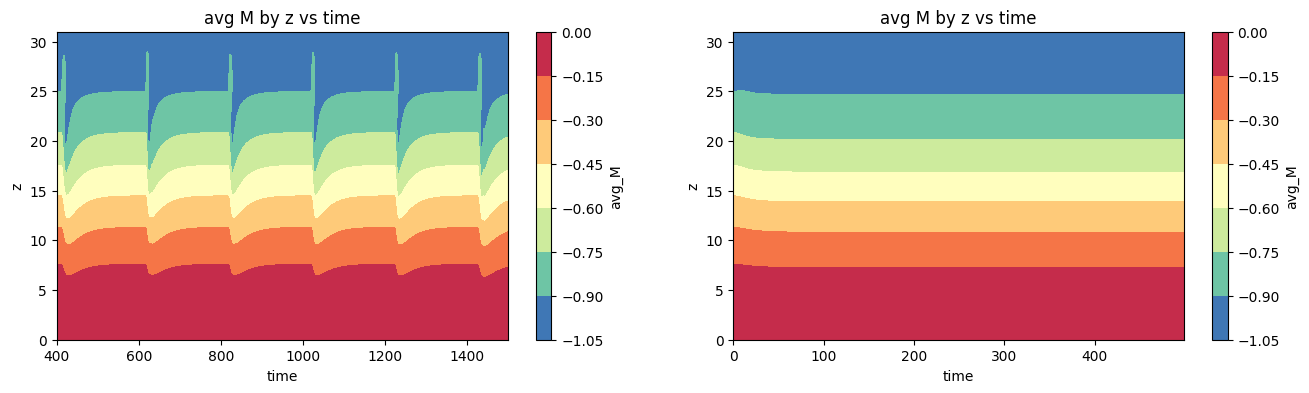

<Figure size 640x480 with 0 Axes>

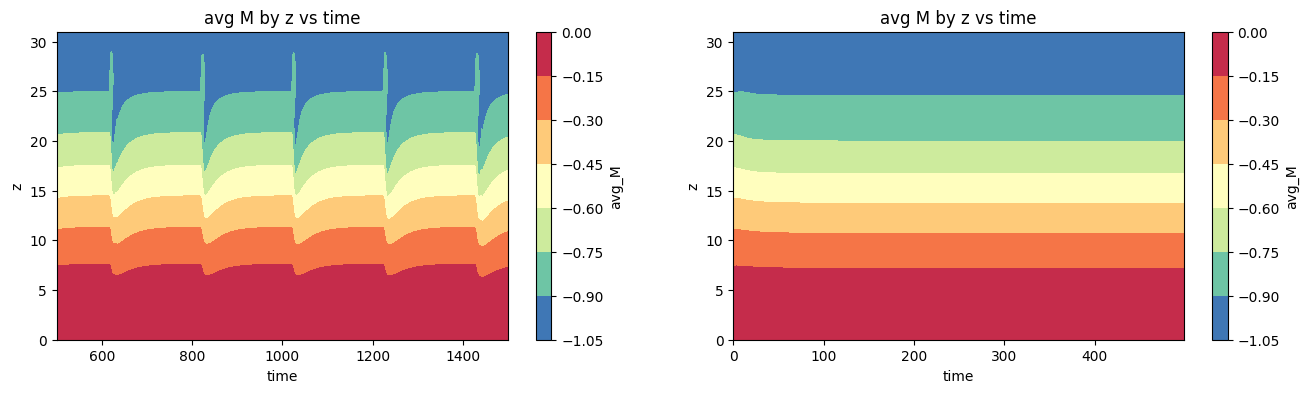

<Figure size 640x480 with 0 Axes>

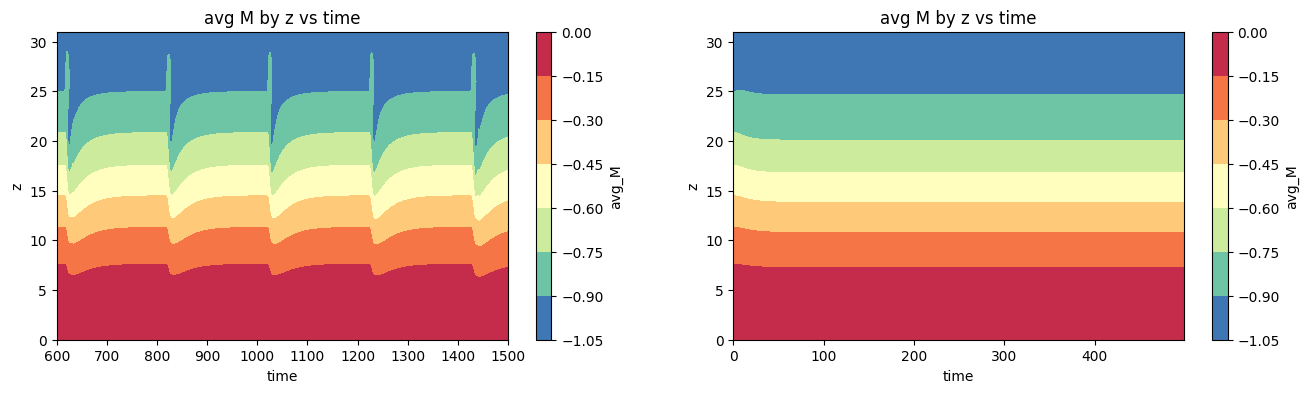

<Figure size 640x480 with 0 Axes>

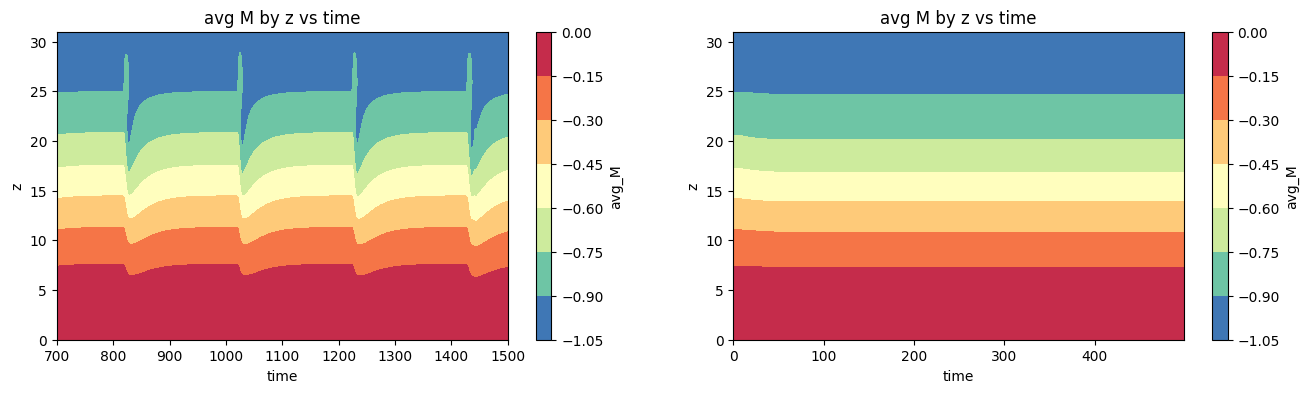

<Figure size 640x480 with 0 Axes>

In [9]:
for beginning_time in range(0, 800, 100):
    local_look(beginning_time, 1500, avg_M_all_time, 'M')

In [14]:
beg_os_t = 1
end_os_t = 1500
beg_height = 25
print(avg_KE_all_time.shape)
sample_data_KE = avg_KE_all_time[:,beg_os_t:end_os_t]
phi_KE, Lam_KE, b_KE = DMD(sample_data_KE)
#print(phi_KE[0])
print(Lam_KE)
#print(b_KE[0])
sample_data_M = avg_M_all_time[:,beg_os_t:end_os_t]
phi_M, Lam_M, b_M = DMD(sample_data_M)
#sample_data_nD = avg_nD_all_time[beg_os_t:end_os_t, :]
#phi_nD, Lam_nD, b_nD = DMD(sample_data_nD.T)

dt = 1
timesteps = 500
future_KE = compute_future_states(phi_KE, Lam_KE, b_KE, timesteps, 1)
future_M = compute_future_states(phi_M, Lam_M, b_M, timesteps, 1)
#future_nD = compute_future_states(phi_nD, Lam_nD, b_nD, timesteps, 1)


(32, 1500)
[-0.59541527+0.j         -0.53775015+0.22485138j -0.53775015-0.22485138j
 -0.01041765+0.5611714j  -0.01041765-0.5611714j  -0.27154157+0.j
 -0.20089876+0.26320585j -0.20089876-0.26320585j  0.22607121+0.57424948j
  0.22607121-0.57424948j  0.54375987+0.6206106j   0.54375987-0.6206106j
  0.32805453+0.51818492j  0.32805453-0.51818492j  0.70511927+0.49484213j
  0.70511927-0.49484213j  0.12340876+0.25817099j  0.12340876-0.25817099j
  0.82703579+0.30946318j  0.82703579-0.30946318j  0.28784578+0.28651505j
  0.28784578-0.28651505j  0.89690271+0.j          0.63411799+0.28321474j
  0.63411799-0.28321474j  0.81114771+0.10419137j  0.81114771-0.10419137j
  0.79737634+0.08392603j  0.79737634-0.08392603j  0.5798643 +0.j
  0.45135736+0.18129142j  0.45135736-0.18129142j]


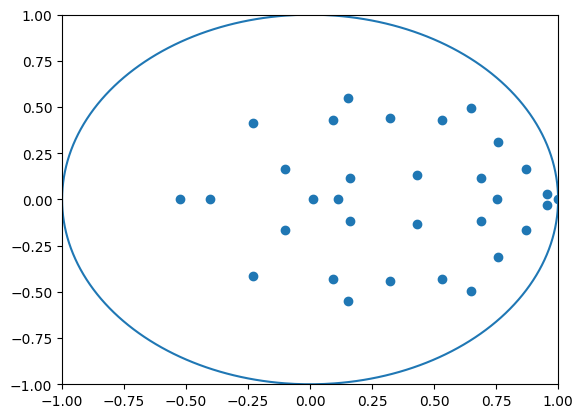

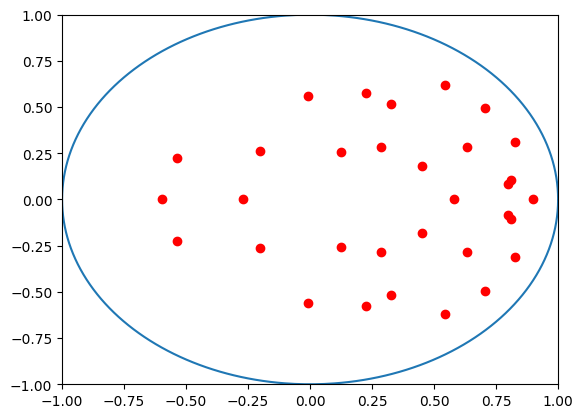

In [15]:
dummy = np.arange(0,2 *np.pi,0.01)
plt.scatter(np.real(Lam_M),np.imag(Lam_M))
plt.plot(np.cos(dummy),np.sin(dummy))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()
plt.scatter(np.real(Lam_KE),np.imag(Lam_KE),color = 'r')

plt.plot(np.cos(dummy),np.sin(dummy))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()


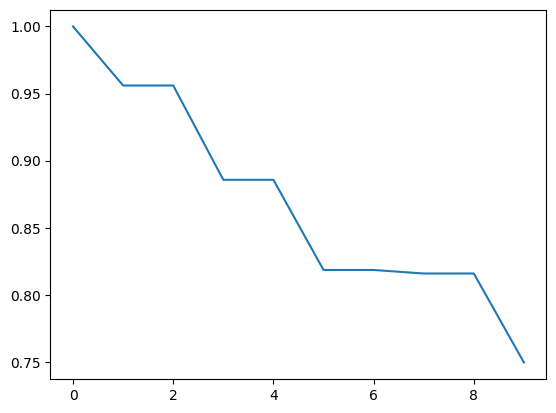

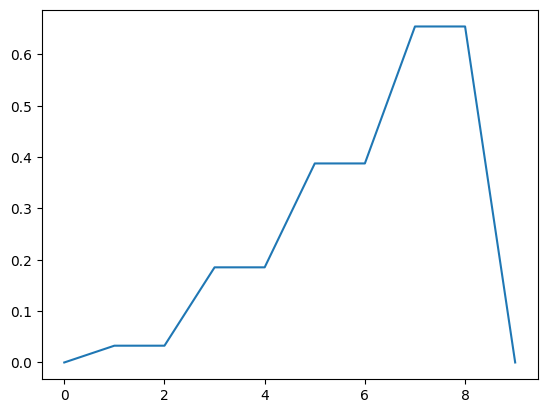

192.1671752885785


In [12]:
Lam_M_sort = Lam_M[np.argsort(-np.abs(Lam_M))]
plt.plot(np.abs(Lam_M_sort[:10]))
plt.show()
plt.plot(np.abs(np.angle(Lam_M_sort[:10])))
plt.show()
print(2* np.pi/np.abs(np.angle(Lam_M_sort[1])))

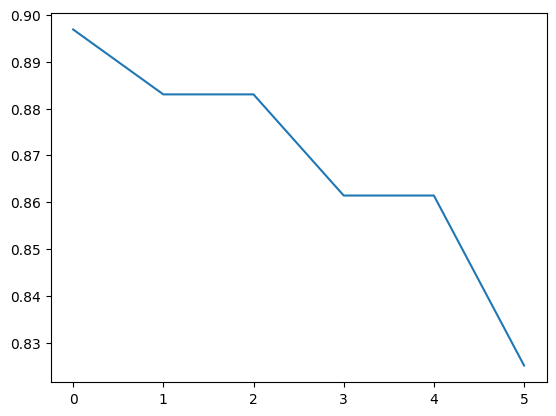

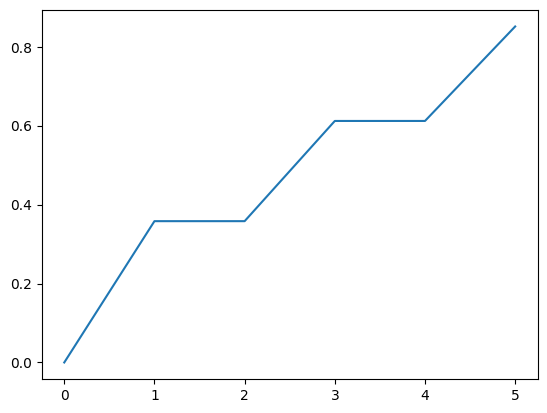

17.54811701799332


In [16]:
Lam_KE_sort = Lam_KE[np.argsort(-np.abs(Lam_KE))]
plt.plot(np.abs(Lam_KE_sort[:6]))
plt.show()
plt.plot(np.abs(np.angle(Lam_KE_sort[:6])))
plt.show()
print(2* np.pi/np.abs(np.angle(Lam_KE_sort[2])))

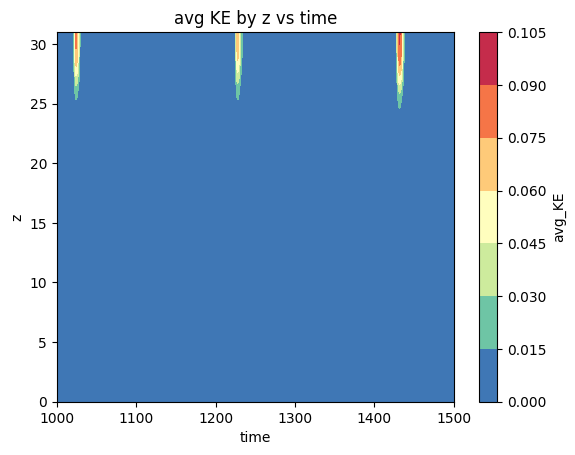

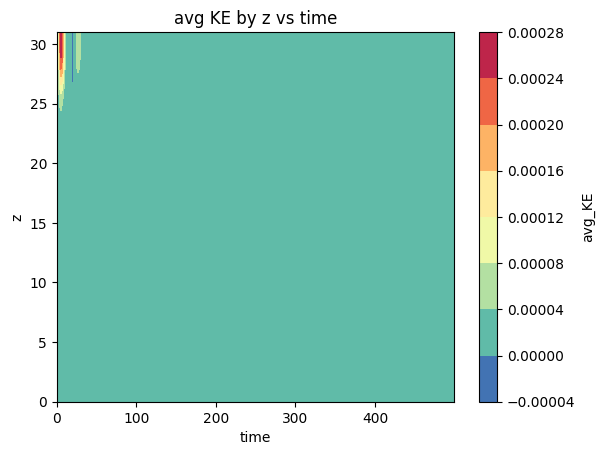

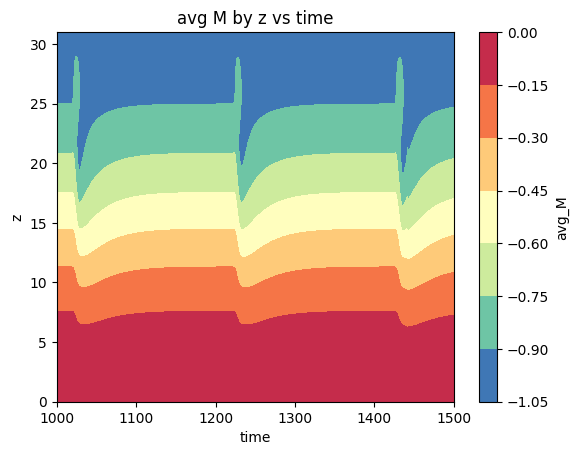

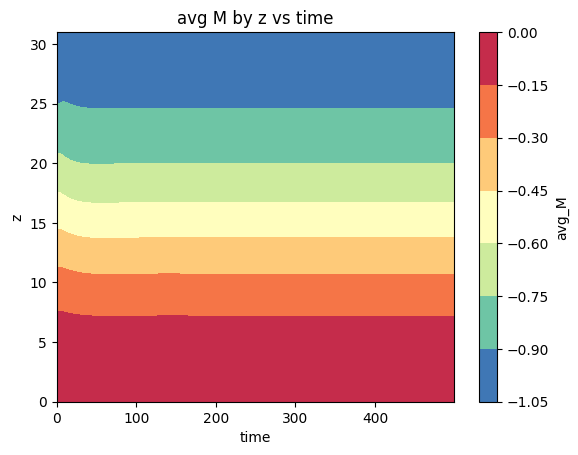

"\nplt.contourf(X_ax, Y_ax, avg_nD_loc_T, cmap='Spectral_r')\nplt.colorbar(label='avg_nD')\nplt.xlabel('time')\nplt.ylabel('z')\nplt.title('avg nD by z vs time')\n# plt.savefig(f'avg_KE_local.png', dpi=200,bbox_inches='tight')\nplt.show()\nmatplotlib.pyplot.close()\n\nplt.contourf(future_nD, cmap='Spectral_r')\nplt.colorbar(label='avg_nD')\nplt.xlabel('time')\nplt.ylabel('z')\nplt.title('avg nD by z vs time')\n# plt.savefig(f'predict_avg_KE_t.png', dpi=200,bbox_inches='tight')\nplt.show()\nmatplotlib.pyplot.close()"

In [10]:
beg_os_t = 1000
end_os_t = 1500
avg_KE_loc_T=avg_KE_all_time[:, beg_os_t:end_os_t] # This is where we want to show from the sample data
avg_M_loc_T=avg_M_all_time[:, beg_os_t:end_os_t]

phi_KE, Lam_KE, b_KE = DMD(avg_KE_loc_T)
phi_M, Lam_M, b_M = DMD(avg_M_loc_T)
#sample_data_nD = avg_nD_all_time[beg_os_t:end_os_t, :]
#phi_nD, Lam_nD, b_nD = DMD(sample_data_nD.T)

dt = 1
timesteps = 500
future_KE = compute_future_states(phi_KE, Lam_KE, b_KE, timesteps, 1)
future_M = compute_future_states(phi_M, Lam_M, b_M, timesteps, 1)

n_rows, n_columns = avg_KE_loc_T.shape
x_ax = np.linspace(beg_os_t, end_os_t, n_columns)
y_ax = np.linspace(0, n_rows-1, n_rows)
X_ax, Y_ax = np.meshgrid(x_ax, y_ax)

# KEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKE
plt.contourf(X_ax, Y_ax, avg_KE_loc_T, cmap='Spectral_r')
plt.colorbar(label='avg_KE')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg KE by z vs time')
# plt.savefig(f'avg_KE_local.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()

plt.contourf(future_KE, cmap='Spectral_r')
plt.colorbar(label='avg_KE')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg KE by z vs time')
# plt.savefig(f'predict_avg_KE_t.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()

# MMMMMMMMMMMMMMMMMMMMMMMMMMMMMM
plt.contourf(X_ax, Y_ax, avg_M_loc_T, cmap='Spectral_r')
plt.colorbar(label='avg_M')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg M by z vs time')
# plt.savefig(f'avg_KE_local.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()

plt.contourf(future_M, cmap='Spectral_r')
plt.colorbar(label='avg_M')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg M by z vs time')
# plt.savefig(f'predict_avg_KE_t.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()

# DDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
"""
plt.contourf(X_ax, Y_ax, avg_nD_loc_T, cmap='Spectral_r')
plt.colorbar(label='avg_nD')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg nD by z vs time')
# plt.savefig(f'avg_KE_local.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()

plt.contourf(future_nD, cmap='Spectral_r')
plt.colorbar(label='avg_nD')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg nD by z vs time')
# plt.savefig(f'predict_avg_KE_t.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()"""

In [ ]:
# The following are saved for debugging purpose
"""
recorded = False
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        st = file['scales/sim_time']
        simtime = np.array(st)
        avg_KE_0 = file["tasks"]["avg KE by z"]
        avg_KE = np.reshape(avg_KE_0, (len(simtime),Nz))
        for t in range(len(simtime)):
            avg_KE_T=np.transpose(avg_KE[t,:])
            avg_KE_T = np.reshape(avg_KE_T, (1, Nz))
            if recorded == False:
                avg_KE_all_time = avg_KE_T
                recorded = True
            else:
                avg_KE_all_time = np.concatenate((avg_KE_all_time, avg_KE_T))
print(np.shape(avg_KE_all_time))
print(np.shape(np.transpose(avg_KE_all_time[:,:])))
avg_KE_allt_T=np.transpose(avg_KE_all_time[:,:])
plt.contourf(avg_KE_allt_T, cmap='Spectral_r')
plt.colorbar(label='avg_KE')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg KE by z vs time')
plt.savefig(f'avg_KE_t.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()"""
"""
recorded = False
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        avg_M_0 = file["tasks"]["avg M by z"]
        avg_M = np.reshape(avg_M_0, (len(simtime), Nz)) # which is (1000, 32)
        st = file['scales/sim_time']
        simtime = np.array(st)
        for t in range(len(simtime)):
            avg_M_T=np.transpose(avg_M[t,:])
            avg_M_T = np.reshape(avg_M_T, (1, Nz))
            if recorded == False:
                avg_M_all_time = avg_M_T
                recorded = True
            else:
                avg_M_all_time = np.concatenate((avg_M_all_time, avg_M_T))
print(np.shape(avg_M_all_time))
print(np.shape(np.transpose(avg_M_all_time[:,:])))
avg_M_allt_T=np.transpose(avg_M_all_time[:,:])
plt.contourf(avg_M_allt_T, cmap='Spectral_r')
plt.colorbar(label='avg_M')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg_M_by_z_vs_time')
plt.savefig(f'avg_M_t.png', dpi=200,bbox_inches='tight')
plt.show()

matplotlib.pyplot.close()
"""
"""recorded = False
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        avg_nD_0 = file["tasks"]["avg -D by z"]
        avg_nD = np.reshape(avg_nD_0, (len(simtime), Nz)) # which is (1000, 32)
        st = file['scales/sim_time']
        simtime = np.array(st)
        for t in range(len(simtime)):
            avg_nD_T=np.transpose(avg_nD[t,:])
            avg_nD_T = np.reshape(avg_nD_T, (1, Nz))
            if recorded == False:
                avg_nD_all_time = avg_nD_T
                recorded = True
            else:
                avg_nD_all_time = np.concatenate((avg_nD_all_time, avg_nD_T))
print(np.shape(avg_nD_all_time))
print(np.shape(np.transpose(avg_nD_all_time[:,:])))
avg_nD_allt_T=np.transpose(avg_nD_all_time[:,:])
plt.contourf(avg_nD_allt_T, cmap='Spectral_r')
plt.colorbar(label='avg_nD')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg -D by z vs time')
plt.savefig(f'avg_nD_t.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()"""